# Visualization

## Import

In [1]:
from functools import partial
from pathlib import Path
import pickle

import numpy as np
import jax
import jax.numpy as jnp
from flax.training.train_state import TrainState
from flax import serialization
import optax
import pandas as pd

from common.cell import to_rgb, make_ellipse_mask
from common.pool import Pool
from common.nca import NCA_big as NCA
from common.vae import vae_dict, vae_loss
from common.utils import Config, load_face, visualize_nca, load_params

import tqdm
import hydra
from hydra.core.config_store import ConfigStore
from omegaconf import OmegaConf

## Load experiment

In [3]:
from pathlib import Path


run_path = Path("/project/output/face/2023-08-14_111948_966482")
config = OmegaConf.load(run_path / ".hydra" / "config.yaml")

## Init

In [3]:
# Init a random key
random_key = jax.random.PRNGKey(config.seed)

# Experiment
use_pattern_pool = {"Growing": 0, "Persistent": 1, "Regenerating": 1}[config.exp.experiment_type]
n_damages = {"Growing": 0, "Persistent": 0, "Regenerating": 3}[config.exp.experiment_type]

# Load VAE
vae_dir = Path(config.exp.vae_dir)
vae_config = OmegaConf.load(vae_dir / ".hydra" / "config.yaml")

# Load list_attr_celeba.txt file into a pandas DataFrame
df_attr_celeba = pd.read_csv(vae_config.exp.attr_dir, sep="\s+", skiprows=1)
df_attr_celeba.replace(to_replace=-1, value=0, inplace=True) # replace -1 by 0

# Load list_landmarks_align_celeba.txt file into a pandas DataFrame
df_landmarks_align_celeba = pd.read_csv(vae_config.exp.landmarks_dir, sep="\s+", skiprows=1)

# Crop images from (218, 178) to (178, 178)
df_landmarks_align_celeba["lefteye_y"] = df_landmarks_align_celeba["lefteye_y"] - (218 - 178) / 2
df_landmarks_align_celeba["righteye_y"] = df_landmarks_align_celeba["righteye_y"] - (218 - 178) / 2
df_landmarks_align_celeba["nose_y"] = df_landmarks_align_celeba["nose_y"] - (218 - 178) / 2
df_landmarks_align_celeba["leftmouth_y"] = df_landmarks_align_celeba["leftmouth_y"] - (218 - 178) / 2
df_landmarks_align_celeba["rightmouth_y"] = df_landmarks_align_celeba["rightmouth_y"] - (218 - 178) / 2

# Resize images from (178, 178) to face_shape
df_landmarks_align_celeba /= 178/vae_config.exp.face_shape[0]

# Dataset
height, width = vae_config.exp.face_shape[:2]
dataset_size = df_landmarks_align_celeba.shape[0]
dataset_size = 20
if vae_config.exp.grayscale:
    dataset_phenotypes_target = np.zeros((dataset_size, *vae_config.exp.face_shape, 1))
else:
    dataset_phenotypes_target = np.zeros((dataset_size, *vae_config.exp.face_shape, 3))

mask = np.zeros((dataset_size, height, width, 1,))
for i, (index, row,) in tqdm.tqdm(enumerate(df_landmarks_align_celeba.iterrows()), total=dataset_size):
    dataset_phenotypes_target[i] = load_face(vae_config.exp.dataset_dir + index, vae_config.exp.face_shape, vae_config.exp.grayscale)
    center = (row["lefteye_x"] + row["righteye_x"]) / 2, (row["lefteye_y"] + row["righteye_y"]) / 2
    mask[i, ..., 0] = make_ellipse_mask(center, width, height, 0.7*width/2, 0.9*height/2)
    if i == dataset_size-1:
        break
dataset_phenotypes_target = dataset_phenotypes_target * mask

# VAE
vae = vae_dict[vae_config.exp.vae_index](img_shape=dataset_phenotypes_target[0].shape, latent_size=vae_config.exp.latent_size)
random_key, random_subkey_1, random_subkey_2 = jax.random.split(random_key, 3)
vae_params = vae.init(random_subkey_1, random_subkey_2, dataset_phenotypes_target[0])
with open(vae_dir / "vae.pickle", "rb") as params_file:
    state_dict = pickle.load(params_file)
vae_params = serialization.from_state_dict(vae_params, state_dict)
param_count = sum(x.size for x in jax.tree_util.tree_leaves(vae_params))
print("Number of parameters: ", param_count)

# Cell states
if vae_config.exp.grayscale:
    phenotype_size = 1
    cell_state_size = phenotype_size + 1 + config.exp.hidden_size
else:
    phenotype_size = 3
    cell_state_size = phenotype_size + 1 + config.exp.hidden_size

@jax.jit
def phenotype_to_genotype(random_key, phenotype_target):
    z, _, _ = vae.apply(vae_params, random_key, phenotype_target, method=vae.encode)
    return z

@jax.jit
def init_cell_state():
    cell_state = jnp.zeros((phenotype_size+1+config.exp.hidden_size,))  # init cell_state
    cell_state = cell_state.at[phenotype_size:].set(1.0)  # set alpha and hidden channels to 1.0
    return cell_state

@jax.jit
def init_cells_state(_):
    cell_state = init_cell_state()
    cells_state = jnp.zeros((height, width, cell_state_size,))
    return cells_state.at[height//2, width//2].set(cell_state)

def phenotype_to_genotype_scan(carry, x):
    random_key, phenotype_target = x
    z = phenotype_to_genotype(random_key, phenotype_target)
    return (), z

random_keys = jax.random.split(random_key, 1+dataset_phenotypes_target.shape[0])
random_key, random_keys = random_keys[-1], random_keys[:-1]
_, dataset_genotypes_target = jax.lax.scan(
    phenotype_to_genotype_scan,
    (),
    (random_keys, dataset_phenotypes_target),
    length=dataset_phenotypes_target.shape[0])

# Trainset - Testset phenotypes
dataset_phenotypes_target = np.concatenate([dataset_phenotypes_target, mask], axis=-1)
trainset_phenotypes_target = dataset_phenotypes_target[:int(0.9 * len(dataset_phenotypes_target))]
testset_phenotypes_target = dataset_phenotypes_target[int(0.9 * len(dataset_phenotypes_target)):]

# Trainset - Testset genotypes
trainset_genotypes_target = dataset_genotypes_target[:int(0.9 * len(dataset_genotypes_target))]
testset_genotypes_target = dataset_genotypes_target[int(0.9 * len(dataset_genotypes_target)):]

# Pool
phenotypes_target_idx_init = jax.random.choice(random_key, trainset_phenotypes_target.shape[0], shape=(config.exp.pool_size,), replace=True)
cells_states_init = jax.vmap(init_cells_state)(phenotypes_target_idx_init)
genotypes_target_init = jnp.take(trainset_genotypes_target, phenotypes_target_idx_init, axis=0)
pool = Pool(cells_states=cells_states_init, phenotypes_target_idx=phenotypes_target_idx_init)

# NCA
nca = NCA(cell_state_size=cell_state_size, fire_rate=config.exp.fire_rate)
random_key, random_subkey_1, random_subkey_2 = jax.random.split(random_key, 3)
params = nca.init(random_subkey_1, random_subkey_2, cells_states_init[0], genotypes_target_init[0])
params = nca.set_kernel(params)

# Train state
lr_sched = optax.linear_schedule(init_value=config.exp.learning_rate, end_value=0.1*config.exp.learning_rate, transition_steps=2000)

def zero_grads():
    def init_fn(_):
        return ()

    def update_fn(updates, state, params=None):
        return jax.jax.tree_util.tree_map(jnp.zeros_like, updates), ()
    return optax.GradientTransformation(init_fn, update_fn)

optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=lr_sched),)
tx = optax.multi_transform({False: optimizer, True: zero_grads()},
                            nca.get_perceive_mask(params))


 95%|█████████▌| 19/20 [00:00<00:00, 22.11it/s]


Number of parameters:  34510979


In [4]:
# params = load_params(params, run_path / "nca.pickle")

train_state = TrainState.create(
    apply_fn=nca.apply,
    params=params,
    tx=tx)

In [5]:
@jax.jit
def scan_apply(carry, random_key):
    (params, cells_states, genotype_target,) = carry
    cells_states_ = train_state.apply_fn(params, random_key, cells_states, genotype_target)
    return (params, cells_states_, genotype_target,), ()

In [43]:
n_iterations = 100
cells_state = init_cells_state(None)
phenotype_target = testset_phenotypes_target[0]
genotype_target = testset_genotypes_target[0]

random_keys = jax.random.split(random_key, n_iterations)
(params, cells_states_, _,), _ = jax.lax.scan(
    scan_apply,
    (params, cells_state, genotype_target,),
    random_keys,
    length=n_iterations,)

In [54]:
n_iterations = 64
cells_state = init_cells_state(None)
phenotype_target = trainset_phenotypes_target[0]
genotype_target = trainset_genotypes_target[0]

random_keys = jax.random.split(random_key, n_iterations)
(params, cells_state_, _,), _ = jax.lax.scan(
    scan_apply,
    (params, cells_state, genotype_target,),
    random_keys,
    length=n_iterations,)

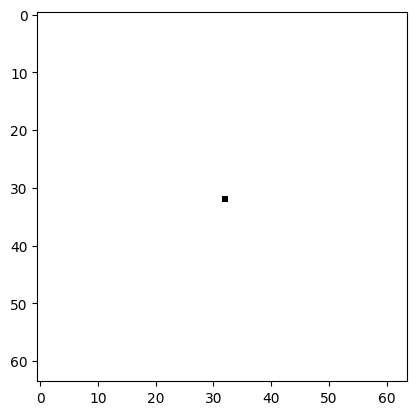

In [55]:
import matplotlib.pyplot as plt
from common.utils import jnp2pil

plt.imshow(jnp2pil(to_rgb(cells_state)))

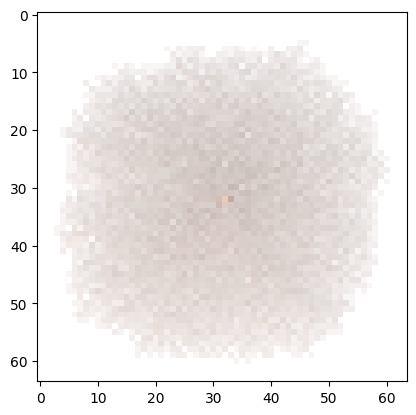

In [56]:
import matplotlib.pyplot as plt
from common.utils import jnp2pil

plt.imshow(jnp2pil(to_rgb(cells_state_)))

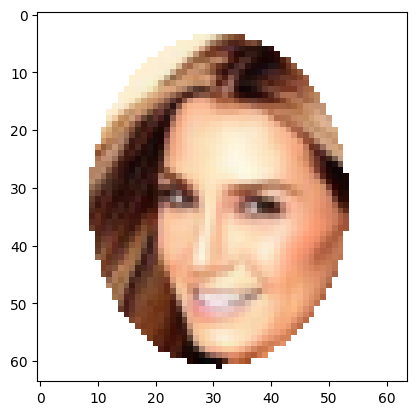

In [57]:
import matplotlib.pyplot as plt
from common.utils import jnp2pil

plt.imshow(jnp2pil(to_rgb(phenotype_target)))

In [9]:
from common.cell import to_rgba
from common.utils import save_params

@jax.jit
def loss_f(cell_states, phenotype):
    return jnp.mean(jnp.square(to_rgba(cell_states) - phenotype), axis=(-1, -2, -3))

In [7]:
@jax.jit
def scan_apply(carry, random_key):
    (params, cells_states, genotype_target,) = carry
    cells_states_ = train_state.apply_fn(params, random_key, cells_states, genotype_target)
    return (params, cells_states_, genotype_target,), ()

In [8]:
@partial(jax.jit, static_argnames=("n_iterations",))
def train_step(random_key, train_state, cells_states, genotype_target, phenotypes_target, n_iterations):
    def loss_fn(params):
        random_keys = jax.random.split(random_key, n_iterations)
        (params, cells_states_, _,), _ = jax.lax.scan(scan_apply, (params, cells_states, genotype_target,), random_keys, length=n_iterations)
        return loss_f(cells_states_, phenotypes_target).mean(), cells_states_

    (loss, cells_states_), grads = jax.value_and_grad(loss_fn, has_aux=True)(train_state.params)
    train_state = train_state.apply_gradients(grads=grads)

    return train_state, loss, cells_states_

In [14]:
config.exp.batch_size = 4

In [15]:
loss_log = []
from common.cell import make_circle_masks
for i in range(50):
    random_key, random_subkey_1, random_subkey_2, random_subkey_3, random_subkey_4, random_subkey_5 = jax.random.split(random_key, 6)

    if use_pattern_pool:
        # Sample cells' states from pool
        idx, cells_states, phenotypes_target_idx = pool.sample(random_subkey_1, config.exp.batch_size)

        # Rank by loss
        loss_rank = jnp.flip(jnp.argsort(loss_f(cells_states, jnp.take(trainset_phenotypes_target, phenotypes_target_idx, axis=0))))
        idx = jnp.take(idx, loss_rank, axis=0)
        cells_states = jnp.take(cells_states, loss_rank, axis=0)
        phenotypes_target_idx = jnp.take(phenotypes_target_idx, loss_rank, axis=0)

        # Sample new phenotype target
        new_phenotype_target_idx = jax.random.randint(random_subkey_2, shape=(), minval=0, maxval=trainset_phenotypes_target.shape[0])
        new_cells_state = init_cells_state(jnp.take(trainset_genotypes_target, new_phenotype_target_idx, axis=0))
        cells_states = cells_states.at[0].set(new_cells_state)
        phenotypes_target_idx_ = phenotypes_target_idx.at[0].set(new_phenotype_target_idx)

        if n_damages:
            damage = 1.0 - make_circle_masks(random_subkey_3, n_damages, height, width)[..., None]
            cells_states = cells_states.at[-n_damages:].set(cells_states[-n_damages:] * damage)
    else:
        cells_states = jax.vmap(init_cells_state)(None)

    n_iterations = jax.random.randint(random_subkey_4, shape=(), minval=64, maxval=96)
    genotypes_target = jnp.take(trainset_genotypes_target, phenotypes_target_idx_, axis=0)
    phenotypes_target_ = jnp.take(trainset_phenotypes_target, phenotypes_target_idx_, axis=0)
    train_state, loss, cells_states_ = train_step(random_subkey_5, train_state, cells_states, genotypes_target, phenotypes_target_, int(n_iterations))

    if use_pattern_pool:
        pool = pool.commit(idx, cells_states_, phenotypes_target_idx_)

    loss_log.append(loss)
    print("\r step: %d, log10(loss): %.3f"%(i, jnp.log10(loss)), end="")
save_params(train_state.params, "/project/nca.pickle")

 step: 49, log10(loss): -0.940

OSError: [Errno 30] Read-only file system: 'nca.pickle'

In [16]:
save_params(train_state.params, "/project/nca.pickle")

In [49]:
params = load_params(train_state.params, "/project/nca.pickle")

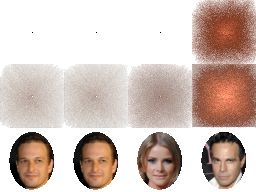

In [37]:
import common.cell as cell
import common.utils as utils

cells_states_before = jnp.hstack(cell.to_rgb(cells_states))
cells_states_after = jnp.hstack(cell.to_rgb(cells_states_))
phenotypes_target = jnp.hstack(cell.to_rgb(phenotypes_target_))
img = jnp.vstack([cells_states_before, cells_states_after, phenotypes_target])

# Save
utils.jnp2pil(img)